Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold,f_classif,chi2,SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [3]:
bank_data = pd.read_csv('https://raw.githubusercontent.com/edyoda/data-science-complete-tutorial/master/Data/bank-full.csv',sep = ';')

In [4]:
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [5]:
bank_data.shape

(45211, 17)

In [6]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
bank_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [8]:
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [9]:
bank_data.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


The target column is 'y' indicating if the client has subscribed for term deposit or not,hence this is a classification problem

In [10]:
target = bank_data.y

In [11]:
feature_data = bank_data.drop(columns = ['y'])

In [14]:
feature_data.shape

(45211, 16)

dividing feature_data into categorical and numerical data

In [15]:
cat_bank_data = feature_data.select_dtypes(include = 'object')
num_bank_data = feature_data.select_dtypes(exclude = 'object')

In [16]:
cat_bank_data.shape

(45211, 9)

In [17]:
num_bank_data.shape

(45211, 7)

### dealing with categorical columns

In [18]:
for col in list(cat_bank_data.columns):
    print(col,bank_data[col].value_counts(),sep = '\n')
    print('-------------------------')

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
-------------------------
marital
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64
-------------------------
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64
-------------------------
default
no     44396
yes      815
Name: default, dtype: int64
-------------------------
housing
yes    25130
no     20081
Name: housing, dtype: int64
-------------------------
loan
no     37967
yes     7244
Name: loan, dtype: int64
-------------------------
contact
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64
-------------------------
month
may    13766
jul     6895
aug     6247
ju

From the above it is clear that    
column 'default' has more number of 'no' comapred to 'yes'        
column 'poutcome' more number of 'unknown'          

* we can drop 'poutcome' directly and for 'default' and such other columns are gonna use Varience Threshold

In [19]:
cat_bank_data.drop(columns = ['poutcome'],inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
## encoding cat_bank_data
oe = OrdinalEncoder()
cat_tf = oe.fit_transform(cat_bank_data)
cat_bank_data_tf = pd.DataFrame(cat_tf,columns = list(cat_bank_data.columns))
cat_bank_data_tf.head()

,job,marital,education,default,housing,loan,contact,month
0,4.0,1.0,2.0,0.0,1.0,0.0,2.0,8.0
1,9.0,2.0,1.0,0.0,1.0,0.0,2.0,8.0
2,2.0,1.0,1.0,0.0,1.0,1.0,2.0,8.0
3,1.0,1.0,3.0,0.0,1.0,0.0,2.0,8.0
4,11.0,2.0,3.0,0.0,0.0,0.0,2.0,8.0


###  removing  columns based on low variance using variance threshold

In [21]:
def filter_variance_threshold(df,threshold):
    vt = VarianceThreshold(threshold = threshold)
    vt_cols = vt.fit_transform(df)
    col_names = list(df.columns[vt.variances_>threshold])
    return pd.DataFrame(vt_cols,columns = col_names)

In [22]:
cat_filtered = filter_variance_threshold(cat_bank_data_tf,0.2)

In [23]:
cat_filtered.columns

Index(['job', 'marital', 'education', 'housing', 'contact', 'month'], dtype='object')

### performing chi2 test to select the most related categorical columns with the target

In [28]:
### function to select k best categorical featuers using any test
def Select_KBest(k,df,target,score_func):
    fs = SelectKBest(k=k,score_func = score_func)
    array = fs.fit_transform(df,target)
    col_names = pd.Series(fs.scores_,index = list(df.columns)).sort_values(ascending=False)[:k].index
    return pd.DataFrame(array,columns = col_names)

In [30]:
cat_df = Select_KBest(4,cat_filtered,target,chi2)
cat_df.head()

,contact,housing,job,education
0,4.0,2.0,1.0,2.0
1,9.0,1.0,1.0,2.0
2,2.0,1.0,1.0,2.0
3,1.0,3.0,1.0,2.0
4,11.0,3.0,0.0,2.0


### Dealing with Categorical columns

In [31]:
num_bank_data.head()

,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


###  removing  columns based on low variance using variance threshold

In [32]:
num_filtered = filter_variance_threshold(num_bank_data,0.2)
num_filtered.head()

,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


#### since none of columns is removed cross checking the varionces of the columns

In [33]:
for col in list(num_bank_data.columns):
    print(col,np.round(num_bank_data[col].var(),2),sep= '        ')

age        112.76
balance        9270598.95
day        69.26
duration        66320.57
campaign        9.6
pdays        10025.77
previous        5.31


### selecting k numerical columns which are in high association with target using Anaova

In [36]:
num_df = Select_KBest(4,num_filtered,target,f_classif)
num_df.head()

,duration,pdays,previous,campaign
0,261,1,-1,0
1,151,1,-1,0
2,76,1,-1,0
3,92,1,-1,0
4,198,1,-1,0


In [49]:
##these are columns that are to included in the data frame which are not of less variance and are not lowly relation with target
col_list = list(pd.concat([cat_df,num_df,target],axis =1).columns)

In [51]:
bank_tf = bank_data[col_list]
bank_tf.head()

,contact,housing,job,education,duration,pdays,previous,campaign,y
0,unknown,yes,management,tertiary,261,-1,0,1,no
1,unknown,yes,technician,secondary,151,-1,0,1,no
2,unknown,yes,entrepreneur,secondary,76,-1,0,1,no
3,unknown,yes,blue-collar,unknown,92,-1,0,1,no
4,unknown,no,unknown,unknown,198,-1,0,1,no


In [64]:
def f(r):
    if r == 'yes':
        return 1
    else:
        return 0
    

bank_tf['y_tf'] = bank_tf.y.map(f)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [65]:
bank_tf.head()

,contact,housing,job,education,duration,pdays,previous,campaign,y,y_tf
0,unknown,yes,management,tertiary,261,-1,0,1,no,0
1,unknown,yes,technician,secondary,151,-1,0,1,no,0
2,unknown,yes,entrepreneur,secondary,76,-1,0,1,no,0
3,unknown,yes,blue-collar,unknown,92,-1,0,1,no,0
4,unknown,no,unknown,unknown,198,-1,0,1,no,0


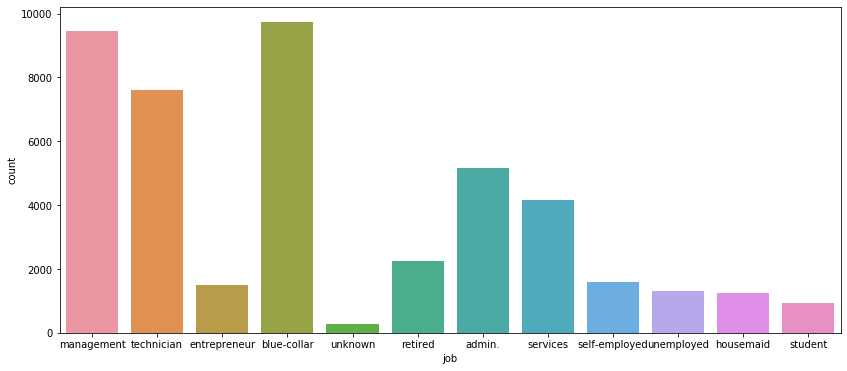

In [61]:
plt.figure(figsize=(14,6))
sns.countplot(bank_tf.job)
plt.show()

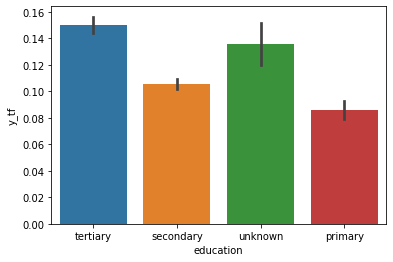

In [70]:
sns.barplot(x='education',y='y_tf',data = bank_tf)
plt.show()

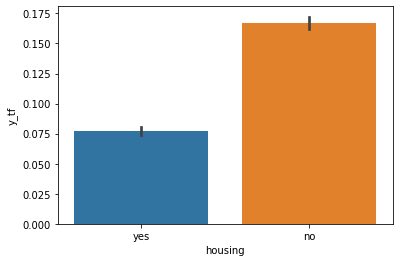

In [71]:
sns.barplot(x='housing',y='y_tf',data = bank_tf)
plt.show()

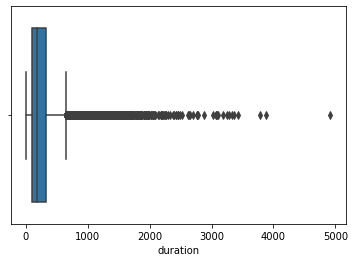

In [82]:
sns.boxplot(bank_tf.duration)

In [83]:
bank_tf.duration.describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

In [193]:
bank_tf.drop(columns= 'y_tf',inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [194]:
## it is clear that there are many outliers in the data, removing them using IQR
Q1 = bank_tf.quantile(0.25)
Q3 = bank_tf.quantile(0.75)
IQR = Q3-Q1 
IQR

duration    216.0
pdays         0.0
previous      0.0
campaign      2.0
dtype: float64

In [195]:
bank_clean = bank_tf[~( (bank_tf < (Q1 - 1.5*IQR ))|(bank_tf>(Q3+1.5*IQR)) ).any(axis =1)]
bank_clean.shape

(31563, 9)

In [204]:
bank_clean.y.value_counts()

no     29583
yes     1980
Name: y, dtype: int64

In [205]:
df = bank_clean.copy()

In [206]:
df.columns

Index(['contact', 'housing', 'job', 'education', 'duration', 'pdays',
       'previous', 'campaign', 'y'],
      dtype='object')

In [207]:
df.y.value_counts()

no     29583
yes     1980
Name: y, dtype: int64

### splitting the data into training and testing

In [208]:
target = df.y
feature = df.drop(columns = 'y')

In [209]:
feature_cat = feature.select_dtypes(include ='object')
feature_num = feature.select_dtypes(exclude ='object')

In [210]:
oe = OrdinalEncoder()
arr = oe.fit_transform(feature_cat)
feature_cat_en = pd.DataFrame(arr,columns = list(feature_cat.columns))

In [211]:
df_algo = feature_num.join(feature_cat_en).join(target).dropna()

In [213]:
trainX,testX,trainY,testY = train_test_split(df_algo.drop(columns = 'y'),df_algo.y)

In [214]:
dt = DecisionTreeClassifier()
dt.fit(trainX,trainY)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [215]:
dt.score(trainX,trainY)

0.9966245177882554

In [216]:
dt.score(testX,testY)

0.9511411121825779

In [217]:
y_pred = dt.predict(testX)

In [222]:
conf_mat = confusion_matrix(y_pred = y_pred ,y_true=testY)

In [223]:
pd.DataFrame(conf_mat,columns = ['pred_no','pred_yes'],index = ['Actual_no','Actual_yes'])

,pred_no,pred_yes
Actual_no,5896,160
Actual_yes,144,22


In [225]:
df_algo.y.value_counts()

no     24198
yes      688
Name: y, dtype: int64

#### the number of 'yes' are very low when compared to 'no', therefore balencing the classes`

In [229]:
sampler = RandomOverSampler()

In [230]:
feature_s,target_s = sampler.fit_sample(df_algo.drop(columns = 'y'),df_algo.y)

In [231]:
pd.Series(target_s).value_counts()

yes    24198
no     24198
dtype: int64

In [232]:
trainX,testX,trainY,testY = train_test_split(feature_s,target_s)
dt = DecisionTreeClassifier()
dt.fit(trainX,trainY)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

#### Accuracies after balancing classes

In [234]:
print('Train_Acc :' ,dt.score(trainX,trainY))
print('Test_Acc :' ,dt.score(testX,testY))

Train_Acc : 0.9968316940794005
Test_Acc : 0.982643193652368


In [237]:
y_pred = dt.predict(testX)
conf_mat = confusion_matrix(y_pred = y_pred ,y_true=testY)
pd.DataFrame(conf_mat,columns = ['pred_no','pred_yes'],index = ['Actual_no','Actual_yes'])

,pred_no,pred_yes
Actual_no,5773,210
Actual_yes,0,6116


#### the model has good accuracy,now lets see if we can reduce the dimensions without reducing accuracy

In [241]:
feature_importances = dt.feature_importances_
feature_importances

array([0.65933868, 0.        , 0.        , 0.07568242, 0.05388921,
       0.04281359, 0.12205376, 0.04622234])

In [245]:
cols = list(df_algo.drop(columns ='y').columns)
cols 

['duration',
 'pdays',
 'previous',
 'campaign',
 'contact',
 'housing',
 'job',
 'education']

In [247]:
pd.Series(feature_importances,index = cols).sort_values(ascending = False)

duration     0.659339
job          0.122054
campaign     0.075682
contact      0.053889
education    0.046222
housing      0.042814
previous     0.000000
pdays        0.000000
dtype: float64

It is clear that 'pdays' and 'previous' has zero feature importances, they can be removed and the model scorew would not be impacted.

lets select only 2 columns which have feature importance greater than 0.1

In [262]:
fea_cols = list((pd.Series(feature_importances,index = cols).sort_values(ascending = False)[:2]).index)
fea_cols

['duration', 'job']

In [263]:
feature_s4 = pd.DataFrame(feature_s,columns = cols)[fea_cols]
feature_s4.head()

,duration,job
0,261.0,4.0
1,151.0,9.0
2,76.0,2.0
3,92.0,1.0
4,198.0,11.0


In [264]:
trainX,testX,trainY,testY = train_test_split(feature_s,target_s)
dt = DecisionTreeClassifier()
dt.fit(trainX,trainY)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [265]:
print('Train_Acc :' ,dt.score(trainX,trainY))
print('Test_Acc :' ,dt.score(testX,testY))

Train_Acc : 0.9968041435931344
Test_Acc : 0.9807422101000083


In [266]:
y_pred = dt.predict(testX)
conf_mat = confusion_matrix(y_pred = y_pred ,y_true=testY)
pd.DataFrame(conf_mat,columns = ['pred_no','pred_yes'],index = ['Actual_no','Actual_yes'])

,pred_no,pred_yes
Actual_no,5821,233
Actual_yes,0,6045


The number of features considered are two : ['duration', 'job']

Train_Accuracy  : 0.9968041435931344   
Test_Accuracy : 0.9807422101000083